In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

x = pd.read_csv('/content/drive/MyDrive/TataSteel10years.csv')
# x = pd.read_csv('TISC Historical Data.csv')

Mounted at /content/drive


In [2]:
x.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,06/19/2024,180.00,182.26,182.48,179.35,27.46M,-0.62%
1,06/18/2024,181.12,183.80,184.60,180.60,35.03M,-1.11%
2,06/14/2024,183.15,182.95,183.50,181.40,28.51M,0.32%
3,06/13/2024,182.56,183.40,184.10,180.51,36.67M,0.18%
4,06/12/2024,182.23,182.25,183.87,181.50,33.31M,0.50%


In [3]:
x['Vol.'] = x['Vol.'].str.replace('M', '').astype(float) * 1e6
x['Change %'] = x['Change %'].str.replace('%', '').astype(float)

In [4]:
reversed_x = x.iloc[::-1]
reversed_x.head()
x_sorted = reversed_x.reset_index(drop=True)

In [5]:
x_sorted['Date'] = pd.to_datetime(x_sorted['Date'])
x_sorted['Price_diff'] = x_sorted['Price'].diff()
x_sorted['Price_diff'][0] = 0
# x_sorted = x_sorted.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)
x_sorted.head()

<ipython-input-5-ccf0e019d80e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_sorted['Price_diff'][0] = 0


,Date,Price,Open,High,Low,Vol.,Change %,Price_diff
0,2014-01-01,38.21,38.13,38.29,38.01,12530000.0,0.39,0.00
1,2014-01-02,37.61,38.22,39.07,37.41,41990000.0,-1.57,-0.60
2,2014-01-03,37.01,37.37,37.63,36.70,33420000.0,-1.60,-0.60
3,2014-01-06,36.63,36.87,37.30,36.30,28390000.0,-1.03,-0.38
4,2014-01-07,35.41,36.78,36.96,35.22,40940000.0,-3.33,-1.22


In [6]:
split = int(len(x_sorted)*0.7)
test = x_sorted[split:]
train = x_sorted[:split]
test = test.reset_index(drop=True)
train = train.reset_index(drop=True)

In [7]:
x.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [8]:
actual_stock_price = test.iloc[:,7:].values
actual_stock_price

array([[-8.000e-02],
       [ 6.200e-01],
       [ 3.080e+00],
       [ 8.150e+00],
       [ 3.400e+00],
       [ 1.750e+00],
       [-5.470e+00],
       [-4.710e+00],
       [ 1.870e+00],
       [ 2.920e+00],
       [-1.570e+00],
       [-5.930e+00],
       [ 8.100e-01],
       [-2.110e+00],
       [ 1.320e+00],
       [-2.310e+00],
       [ 1.460e+00],
       [ 6.800e-01],
       [ 2.220e+00],
       [-2.480e+00],
       [ 2.310e+00],
       [-2.000e-01],
       [-1.300e-01],
       [ 8.000e-01],
       [-1.760e+00],
       [-1.010e+00],
       [ 1.340e+00],
       [ 4.390e+00],
       [ 6.500e-01],
       [ 9.500e-01],
       [-3.220e+00],
       [-3.830e+00],
       [-1.150e+00],
       [ 1.380e+00],
       [ 6.200e-01],
       [-1.220e+00],
       [ 1.310e+00],
       [ 5.210e+00],
       [ 1.870e+00],
       [-1.150e+00],
       [-5.900e-01],
       [-3.000e-01],
       [-2.760e+00],
       [ 2.080e+00],
       [ 1.040e+00],
       [ 5.140e+00],
       [-2.890e+00],
       [ 4.96

In [9]:
# LSTM
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set = train.iloc[:, 1:2].values
training_set_scaled = sc.fit_transform(training_set)

X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

regressor = Sequential()

regressor.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 128, return_sequences = True))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units = 128, return_sequences = True))
regressor.add(Dropout(0.5))

regressor.add(LSTM(units = 128, return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 128))
regressor.add( Dropout(0.5))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_absolute_error'])
regressor.fit(X_train, y_train, epochs = 10, batch_size = 32, verbose=1)


dataset_total = pd.concat((train['Price_diff'], test['Price_diff']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

Epoch 1/10
55/55 [==============================] - 40s 501ms/step - loss: 0.0084 - mean_absolute_error: 0.0654
Epoch 2/10
55/55 [==============================] - 25s 450ms/step - loss: 0.0041 - mean_absolute_error: 0.0470
Epoch 3/10
55/55 [==============================] - 28s 500ms/step - loss: 0.0035 - mean_absolute_error: 0.0444
Epoch 4/10
55/55 [==============================] - 27s 490ms/step - loss: 0.0031 - mean_absolute_error: 0.0412
Epoch 5/10
55/55 [==============================] - 27s 487ms/step - loss: 0.0024 - mean_absolute_error: 0.0359
Epoch 6/10
55/55 [==============================] - 26s 471ms/step - loss: 0.0030 - mean_absolute_error: 0.0415
Epoch 7/10
55/55 [==============================] - 26s 473ms/step - loss: 0.0024 - mean_absolute_error: 0.0357
Epoch 8/10
55/55 [==============================] - 27s 487ms/step - loss: 0.0025 - mean_absolute_error: 0.0367
Epoch 9/10
55/55 [==============================] - 27s 486ms/step - loss: 0.0021 - mean_absolute_error:

In [10]:
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_price_lstm = regressor.predict(X_test)
predicted_price_lstm = sc.inverse_transform(predicted_price_lstm)

25/25 [==============================] - 6s 159ms/step


In [11]:
# MLP Model
X_train_mlp = train[['Price','Open', 'High', 'Low', 'Change %']]
y_train_mlp = train['Price_diff']

X_test_mlp = test[['Price', 'Open', 'High', 'Low', 'Change %']]

from sklearn.neural_network import MLPRegressor, MLPClassifier

mlp = MLPRegressor(hidden_layer_sizes=(64,), max_iter=1000, random_state=1)
mlp.fit(X_train_mlp, y_train_mlp)

predicted_price_mlp = mlp.predict(X_test_mlp)

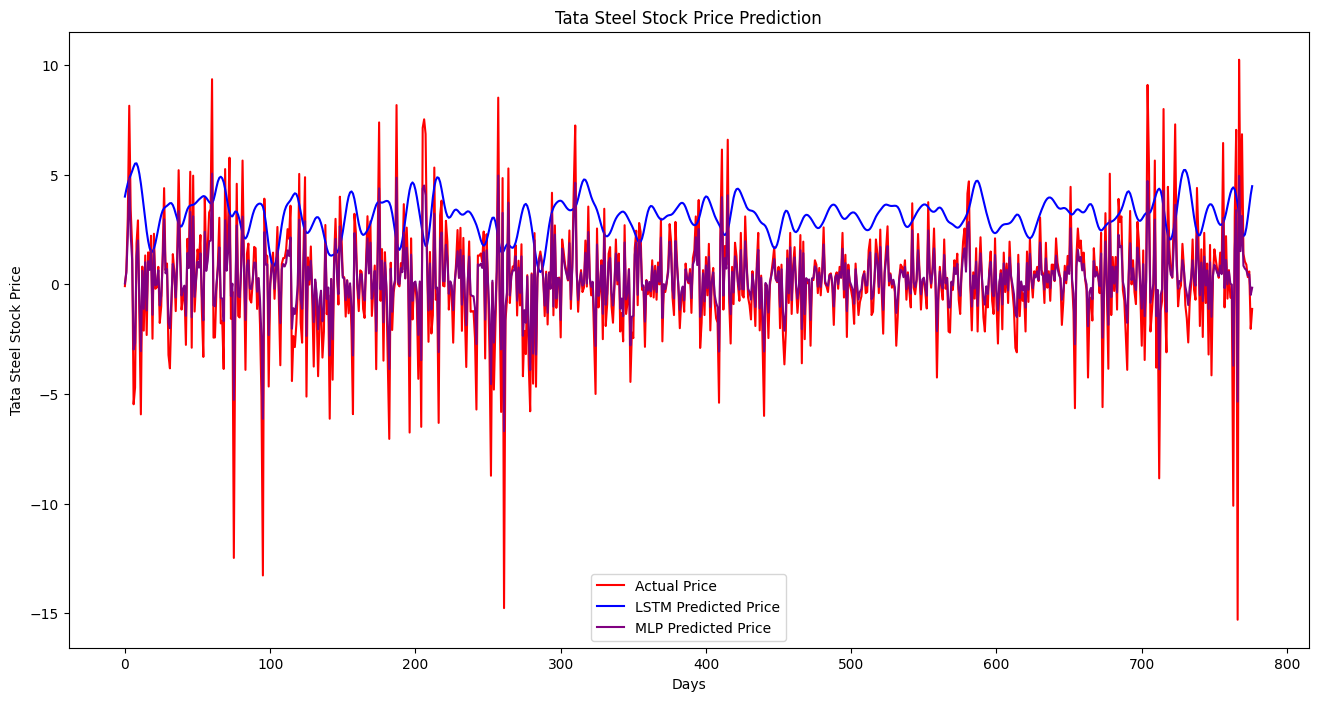

In [12]:
# Plotting results
plt.figure(figsize=(16,8))
plt.plot(actual_stock_price, color = 'red', label = 'Actual Price')
plt.plot(predicted_price_lstm, color = 'blue', label = 'LSTM Predicted Price')
plt.plot(predicted_price_mlp, color = 'purple', label = 'MLP Predicted Price')
plt.title('Tata Steel Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Tata Steel Stock Price')
plt.legend()
plt.show()

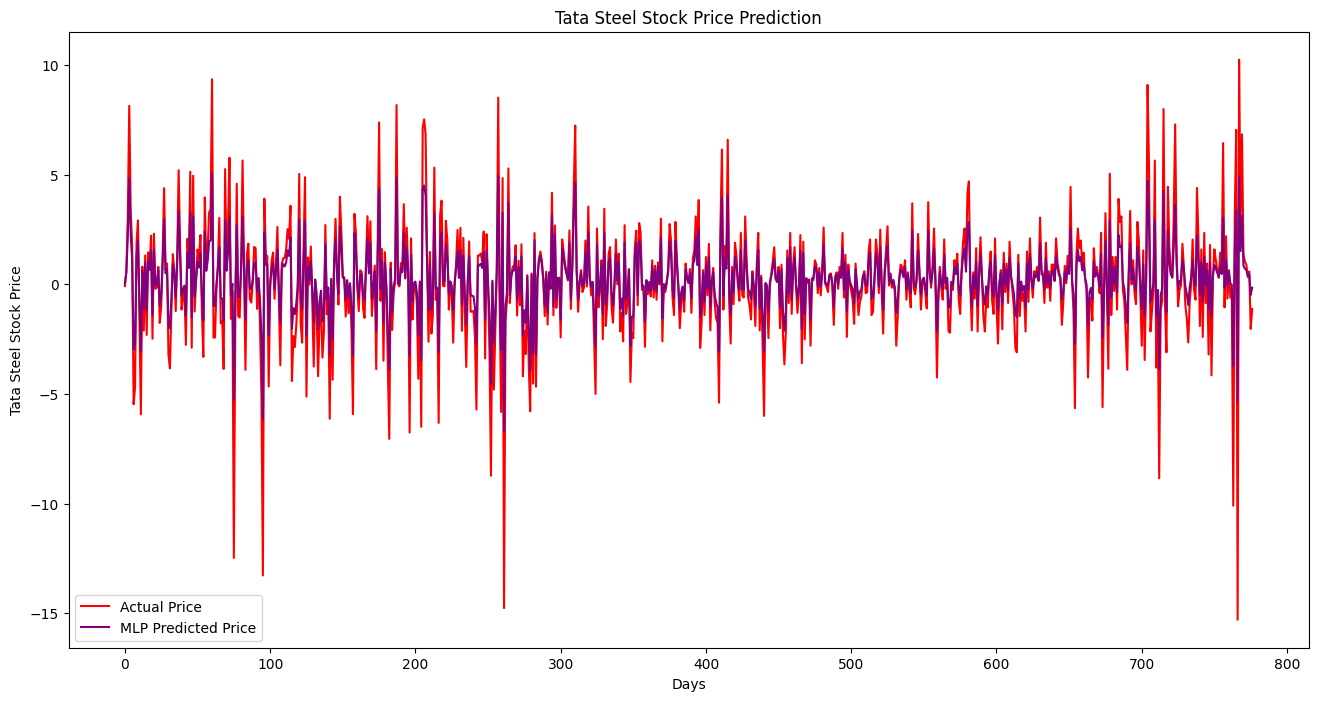

In [13]:
# Plotting results only MLP
plt.figure(figsize=(16,8))
plt.plot(actual_stock_price, color = 'red', label = 'Actual Price')
plt.plot(predicted_price_mlp, color = 'purple', label = 'MLP Predicted Price')
plt.title('Tata Steel Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Tata Steel Stock Price')
plt.legend()
plt.show()

In [17]:
# Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error

def print_metrics(model_name, actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(actual, predicted)
    # mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    mda = median_absolute_error(actual, predicted)
    directional_accuracy = np.mean(np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - actual[:-1])) * 100

    print(f"{model_name} Metrics:")
    print("MAE:", mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAPE:", mape)
    print("Median Absolute Error:", mda)
    print("Directional Accuracy:", directional_accuracy, "%")
    print()

print_metrics("LSTM", actual_stock_price, predicted_price_lstm)
print_metrics("MLP", actual_stock_price, predicted_price_mlp)

LSTM Metrics:
MAE: 3.4170738998588606
MSE: 17.12888751279988
RMSE: 4.138706019132052
MAPE: 195824421055195.62
Median Absolute Error: 3.1117343044281114
Directional Accuracy: 56.44329896907217 %

MLP Metrics:
MAE: 0.812192091425155
MSE: 1.5946616570458427
RMSE: 1.2627991356687898
MAPE: 8557466557116.691
Median Absolute Error: 0.5372850358440857
Directional Accuracy: 68.49492507173981 %



1/1 [==============================] - 0s 62ms/step


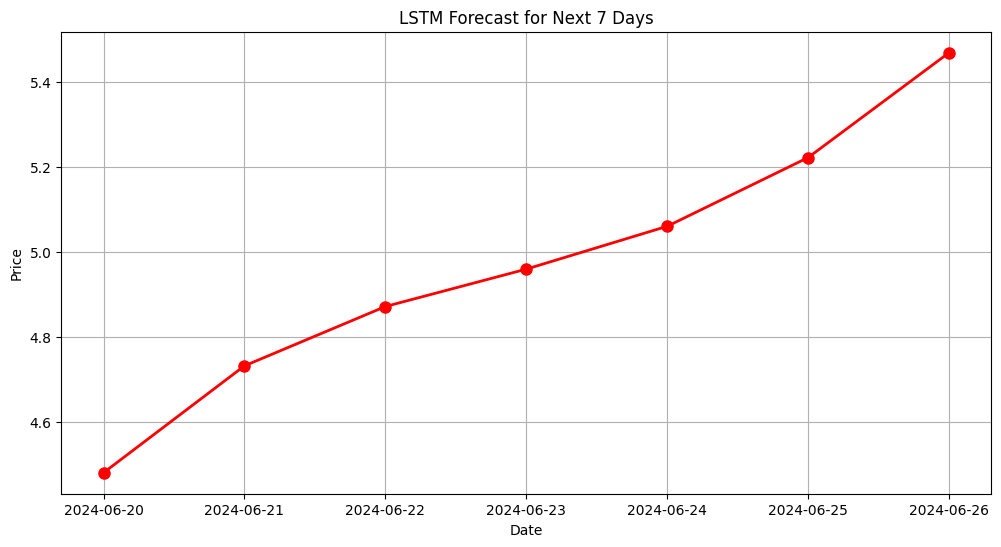

         Date  Forecasted Price
0  2024-06-20          4.480349
1  2024-06-21          4.731725
2  2024-06-22          4.871192
3  2024-06-23          4.959150
4  2024-06-24          5.059921
5  2024-06-25          5.221564
6  2024-06-26          5.468112


In [15]:
predicted_price_next_7_days = []
current_input = X_test[-1]

for i in range(7):
    pred = regressor.predict(current_input.reshape(1, 60, 1))
    predicted_price_next_7_days.append(pred[0, 0])
    current_input = np.append(current_input[1:], pred, axis=0)

predicted_price_next_7_days = np.array(predicted_price_next_7_days).reshape(-1, 1)
predicted_price_next_7_days_scaled = sc.inverse_transform(predicted_price_next_7_days)

last_date = pd.to_datetime('2024-06-19')
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7)

plt.figure(figsize=(12, 6))
plt.plot(forecast_index, predicted_price_next_7_days_scaled, color='red', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.title('LSTM Forecast for Next 7 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

forecast_df = pd.DataFrame({'Date': forecast_index.date, 'Forecasted Price': predicted_price_next_7_days_scaled.flatten()})
print(forecast_df)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPRegress

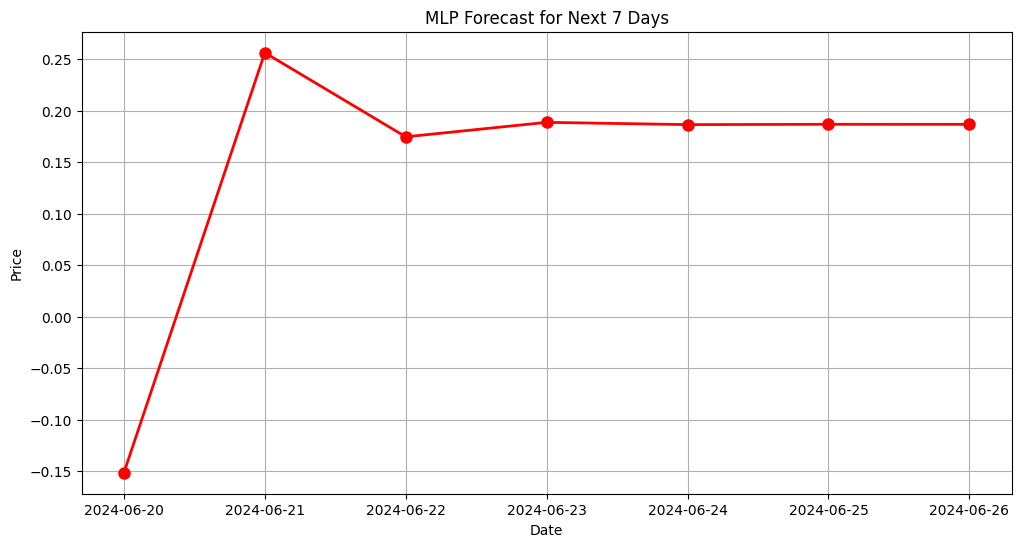

         Date  Forecasted Price
0  2024-06-20         -0.151453
1  2024-06-21          0.256114
2  2024-06-22          0.174505
3  2024-06-23          0.188560
4  2024-06-24          0.186342
5  2024-06-25          0.186655
6  2024-06-26          0.186611


In [16]:
last_known_values = test[['Price', 'Open', 'High', 'Low', 'Change %']].iloc[-1].values.reshape(1, -1)
predicted_price_next_7_days = []

for i in range(7):
    pred = mlp.predict(last_known_values)
    predicted_price_next_7_days.append(pred[0])

    # last_known_values = np.roll(last_known_values, -1)
    # last_known_values[0,-1] = pred[0]

    last_known_values = np.array([pred[0], pred[0], pred[0], pred[0], pred[0]]).reshape(1, -1)

predicted_price_next_7_days = np.array(predicted_price_next_7_days).reshape(-1, 1)

last_date = pd.to_datetime(test['Date'].iloc[-1])
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7)

plt.figure(figsize=(12, 6))
plt.plot(forecast_index, predicted_price_next_7_days, color='red', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.title('MLP Forecast for Next 7 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

forecast_df_mlp = pd.DataFrame({'Date': forecast_index.date, 'Forecasted Price': predicted_price_next_7_days.flatten()})
print(forecast_df_mlp)
